In [1]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
import mystyle

sns.set_palette('colorblind')
sns.set_context('poster')

In [2]:
ati = pd.read_csv('../../data/atium.csv',index_col=0)
ati = ati[ati.eye_flag != 3]
ati = ati[np.isfinite(ati.nus.values)]
print(f'We have {len(ati)} stars')

We have 94 stars


### Read in the JvS+19 models

In [3]:
standard = pd.read_csv('../../data/jvs_models/standard_model.csv', index_col=None)
standard.rename(columns={'# Teff(K)':'Teff', ' Prot(days)':'P',
                         ' Age(Gyr)':'Age',' Mass(Msun)':'M', ' Ro ':'Ro'}, inplace=True)
standard.head(1)

,Teff,P,Age,M,Ro
0,3425.943077,3.132252,2.343081,0.39749,0.028923


In [4]:
rocrit = pd.read_csv('../../data/jvs_models/rocrit_model.csv', index_col=None)
rocrit.rename(columns={'#Teff(K)':'Teff', ' Prot(days)':'P',
                         ' Age(Gyr)':'Age',' Mass(Msun)':'M', ' Ro ':'Ro'}, inplace=True)
rocrit.head(1)

,Teff,P,Age,M,Ro
0,3425.943077,3.132252,2.343081,0.39749,0.028923


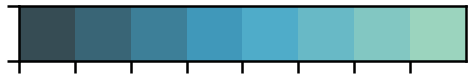

In [5]:
from matplotlib.colors import ListedColormap
snsmap = sns.color_palette('GnBu_d',8)
cmap = ListedColormap(snsmap.as_hex())
sns.palplot(snsmap)

## 1.) Seismic Sample overplotted on "standard" Teff vs Period

This is a TRILEGAL model corrected for the *Kepler* and McQuillan et al. 2014 selection biases. No new (e.g. proposed in JvS+19) detection bias or stellar physics are proposed here.

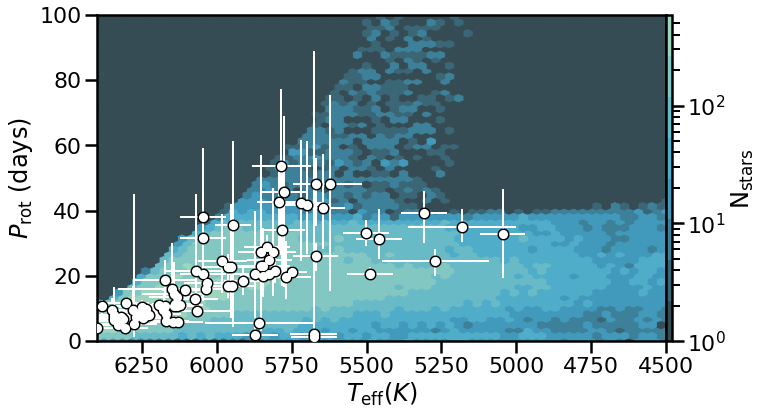

In [6]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
c = ax.hexbin(standard.Teff, standard.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(ati.Teff, ati.P, c='w', s=50,zorder=3)
ax.scatter(ati.Teff, ati.P, c='k', s=100,zorder=2)
ax.errorbar(ati.Teff, ati.P, c='w', lw=2, xerr=ati.eTeff, yerr=[ati.l_P, ati.u_P], fmt='|', zorder=1)
ax.set_ylim(0, 100)
ax.set_xlim(6400, 4500)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

## 2.) The same, but nothing with Ro > 2. Colour coded by whether they have spot modulation or not

$R_{\rm o} = \large\frac{P_{\rm rot}}{\tau_{\rm cv}}$, where

$\log(\tau_{\rm cv}) = 1.16 - 1.49\log(M / M_{\odot}) - 0.54\log(M / M_{\odot})^2$

In [7]:
ati.columns

Index(['KIC', 'Teff', 'age', 'dnu', 'eTeff', 'ednu', 'efeh', 'enumax', 'feh',
       'loage', 'lomodlogg', 'lomodmass', 'lomodrad', 'modlogg', 'modmass',
       'modrad', 'numax', 'source', 'upage', 'upmodlogg', 'upmodmass',
       'upmodrad', 'G', 'bprp', 'hrclass', 'nus*', 'l_nus*', 'u_nus*', 'cosi',
       'l_cosi', 'u_cosi', 'i', 'l_i', 'u_i', 'nus', 'l_nus', 'u_nus', 'P',
       'l_P', 'u_P', 'vsini', 'l_vsini', 'u_vsini', 'fit_numax', 'efit_numax',
       'fit_d01', 'efit_d01', 'fit_d02', 'efit_d02', 'fit_epsilon',
       'efit_epsilon', 'V1', 'eV1', 'V2', 'eV2', 'rhat_flag', 'eye_flag',
       'neff_xsplit', 'neff_cosi', 'neff_split', 'neff_i', 'ebprp'],
      dtype='object')

Use a relation with Teff as the variable. Noyes 1984, Sydney Barnes 2010, Jason Wright (2016-2019?)
Different metallicity makes a star evolve as if it were a different mass, which affects the tau calculation.

In [10]:
Ro = ati.P / 10**(1.16 - 1.49*np.log10(ati.modmass) - 0.54*np.log10(ati.modmass)**2)

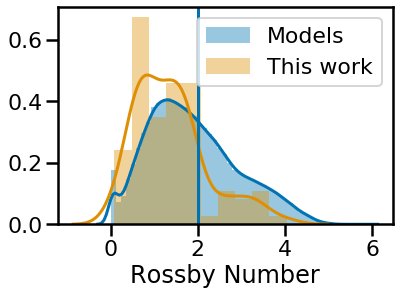

In [11]:
sns.distplot(standard.Ro, label='Models')
sns.distplot(Ro, label='This work')
plt.legend()
plt.axvline(2.)
plt.xlabel('Rossby Number')
s = Ro < 2
sf = standard.Ro.values < 2

This is a TRILEGAL model, corrected for the *Kepler* selection function and MMA14 biases, but only showing stars with a Rossby Number below 2. This checks the proposal that above a certain Rossby number (~2) rotational modulation cannot be measured.

Asteroseismic measurements do not rely on starspots. If asteroseismic measurements align with this model, it implies that whatever is stopping the spot modulation measurements also affects the internal rotation.

In [12]:
lit = pd.read_csv('../../data/lit_spot_rots.csv', index_col=0)
ati = ati.merge(lit, on='KIC', how='left')
ati.index = s.index

I have checked **Nielsen et al. 2013, Santos et al. 2019, McQuillan et al. 2014, and Garcia et al. 2014** for surface rotation.

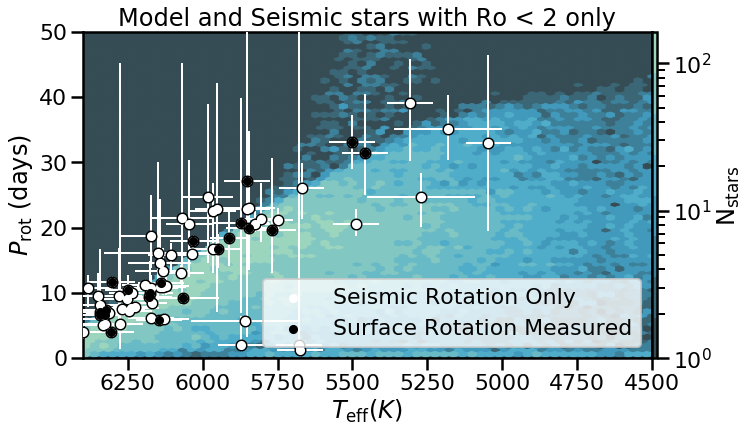

In [13]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
c = ax.hexbin(standard.Teff[sf], standard.P[sf], cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(ati.Teff[s], ati.P[s], c='w', s=50,zorder=5, label='Seismic Rotation Only')
ax.scatter(ati.Teff[s], ati.P[s], c='k', s=100,zorder=4)
ax.errorbar(ati.Teff[s], ati.P[s], c='w', lw=2, 
            xerr=ati.eTeff[s], yerr=[ati.l_P[s], ati.u_P[s]], fmt='|', zorder=3)

s2 = ati.Flag[s] == 1.0
ax.scatter(ati.Teff[s][s2], ati.P[s][s2], c='k', s=50,zorder=5, label='Surface Rotation Measured')


# ax.scatter(ati.Teff[~s], ati.P[~s], c='k', s=50,zorder=2, alpha=.5, label='~Ro > 2')
# ax.scatter(ati.Teff[~s], ati.P[~s], c='w', s=100,zorder=2, alpha=.5)
# ax.errorbar(ati.Teff[~s], ati.P[~s], c='k', lw=2, 
#             xerr=ati.eTeff[~s], yerr=[ati.l_P[~s], ati.u_P[~s]], fmt='|', zorder=1, alpha=.5)

ax.set_ylim(0, 50)
ax.set_xlim(6400, 4500)
ax.set_title('Model and Seismic stars with Ro < 2 only')
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.legend(loc='lower right')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

## 3.) Same, but against all stars in the RoCrit model

This is a TRILEGAL model, corrected for the *Kepler* selection function and MMA14 biases, but only showing stars with a Rossby Number below 2. The TRILEGAL model was evolved under the assumption that magnetic braking is weakened above a Rossby Number of 2.18 (van Saders+2016). This plot checks the proposal that above a certain Rossby number (~2) rotational modulation cannot be measured, **and** that rotational braking is slowed above a critical Rossby Number of 2.18.

If asteroseismic measurements agree with this plot, it implies that there is indeed a weakening of magnetic braking apparent in the internal rotation periods.

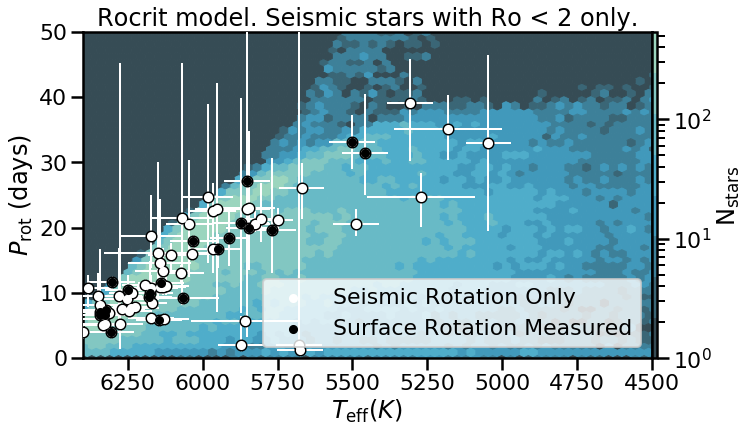

In [14]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(ati.Teff[s], ati.P[s], c='w', s=50,zorder=5, label='Seismic Rotation Only')
ax.scatter(ati.Teff[s], ati.P[s], c='k', s=100,zorder=4)
ax.errorbar(ati.Teff[s], ati.P[s], c='w', lw=2, 
            xerr=ati.eTeff[s], yerr=[ati.l_P[s], ati.u_P[s]], fmt='|', zorder=3)

s2 = ati.Flag[s] == 1.0
ax.scatter(ati.Teff[s][s2], ati.P[s][s2], c='k', s=50,zorder=5, label='Surface Rotation Measured')


ax.set_ylim(0, 50)
ax.set_xlim(6400, 4500)
ax.set_title('Rocrit model. Seismic stars with Ro < 2 only.')
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.legend(loc='lower right')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

In [15]:
ati.columns

Index(['KIC', 'Teff', 'age', 'dnu', 'eTeff', 'ednu', 'efeh', 'enumax', 'feh',
       'loage', 'lomodlogg', 'lomodmass', 'lomodrad', 'modlogg', 'modmass',
       'modrad', 'numax', 'source', 'upage', 'upmodlogg', 'upmodmass',
       'upmodrad', 'G', 'bprp', 'hrclass', 'nus*', 'l_nus*', 'u_nus*', 'cosi',
       'l_cosi', 'u_cosi', 'i', 'l_i', 'u_i', 'nus', 'l_nus', 'u_nus', 'P',
       'l_P', 'u_P', 'vsini', 'l_vsini', 'u_vsini', 'fit_numax', 'efit_numax',
       'fit_d01', 'efit_d01', 'fit_d02', 'efit_d02', 'fit_epsilon',
       'efit_epsilon', 'V1', 'eV1', 'V2', 'eV2', 'rhat_flag', 'eye_flag',
       'neff_xsplit', 'neff_cosi', 'neff_split', 'neff_i', 'ebprp', 'Flag',
       'McQP', 'e_McQP', 'SP', 'e_SP', 'NP', 'e_NP', 'jvsP', 'GP', 'e_GP'],
      dtype='object')

In [16]:
rocrit.columns

Index(['Teff', 'P', 'Age', 'M', ' Ro'], dtype='object')

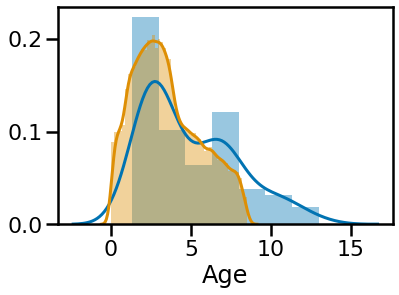

In [17]:
sns.distplot(ati.age);
sns.distplot(rocrit.Age);

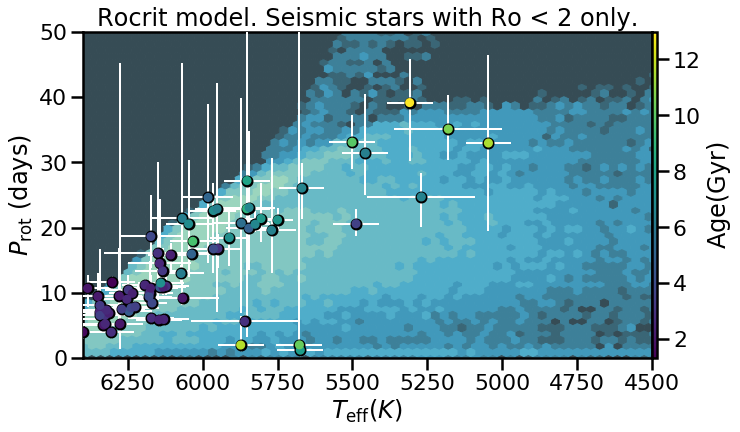

In [18]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
c= ax.scatter(ati.Teff[s], ati.P[s], c=ati.age[s], s=50,zorder=5)
ax.scatter(ati.Teff[s], ati.P[s], c='k', s=100,zorder=4)
ax.errorbar(ati.Teff[s], ati.P[s], c='w', lw=2, 
            xerr=ati.eTeff[s], yerr=[ati.l_P[s], ati.u_P[s]], fmt='|', zorder=3)

ax.set_ylim(0, 50)
ax.set_xlim(6400, 4500)
ax.set_title('Rocrit model. Seismic stars with Ro < 2 only.')
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
fig.colorbar(c,label=r'$\rm{Age (Gyr)}$', pad=0,aspect=60)

What are the seismic biases?

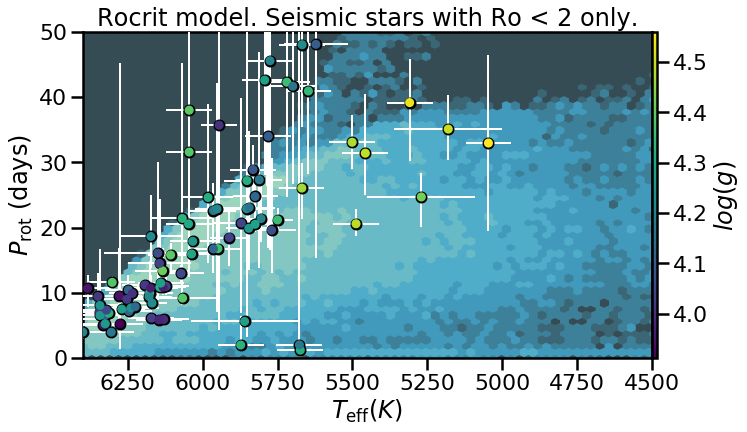

In [19]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
c= ax.scatter(ati.Teff, ati.P, c=ati.modlogg, s=50,zorder=5)
ax.scatter(ati.Teff, ati.P, c='k', s=100,zorder=4)
ax.errorbar(ati.Teff, ati.P, c='w', lw=2, 
            xerr=ati.eTeff, yerr=[ati.l_P, ati.u_P], fmt='|', zorder=3)

ax.set_ylim(0, 50)
ax.set_xlim(6400, 4500)
ax.set_title('Rocrit model. Seismic stars with Ro < 2 only.')
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
fig.colorbar(c,label=r'$log(g)$', pad=0,aspect=60)

## 4) Same, but for all Rossby Numbers

This is a TRILEGAL model, corrected for the *Kepler* selection function and MMA14 biases. The TRILEGAL model was evolved under the assumption that magnetic braking is weakened above a Rossby Number of 2.18 (van Saders+2016). This plot checks the proposal that rotational braking is slowed above a critical Rossby Number of 2.18.

If asteroseismic measurements agree with this plot, it implies that there is indeed a weakening of magnetic braking apparent in the internal rotation periods.

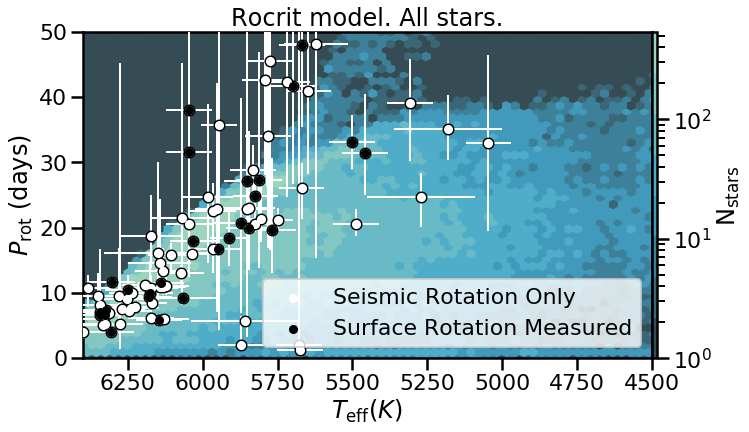

In [20]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(ati.Teff, ati.P, c='w', s=50,zorder=5, label='Seismic Rotation Only')
ax.scatter(ati.Teff, ati.P, c='k', s=100,zorder=4)
ax.errorbar(ati.Teff, ati.P, c='w', lw=2, 
            xerr=ati.eTeff, yerr=[ati.l_P, ati.u_P], fmt='|', zorder=3)

s2 = ati.Flag == 1.0
ax.scatter(ati.Teff[s2], ati.P[s2], c='k', s=50,zorder=5, label='Surface Rotation Measured')

ax.set_ylim(0, 50)
ax.set_xlim(6400, 4500)
ax.set_title('Rocrit model. All stars.')
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.legend(loc='lower right')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

In [21]:
ati.columns

Index(['KIC', 'Teff', 'age', 'dnu', 'eTeff', 'ednu', 'efeh', 'enumax', 'feh',
       'loage', 'lomodlogg', 'lomodmass', 'lomodrad', 'modlogg', 'modmass',
       'modrad', 'numax', 'source', 'upage', 'upmodlogg', 'upmodmass',
       'upmodrad', 'G', 'bprp', 'hrclass', 'nus*', 'l_nus*', 'u_nus*', 'cosi',
       'l_cosi', 'u_cosi', 'i', 'l_i', 'u_i', 'nus', 'l_nus', 'u_nus', 'P',
       'l_P', 'u_P', 'vsini', 'l_vsini', 'u_vsini', 'fit_numax', 'efit_numax',
       'fit_d01', 'efit_d01', 'fit_d02', 'efit_d02', 'fit_epsilon',
       'efit_epsilon', 'V1', 'eV1', 'V2', 'eV2', 'rhat_flag', 'eye_flag',
       'neff_xsplit', 'neff_cosi', 'neff_split', 'neff_i', 'ebprp', 'Flag',
       'McQP', 'e_McQP', 'SP', 'e_SP', 'NP', 'e_NP', 'jvsP', 'GP', 'e_GP'],
      dtype='object')

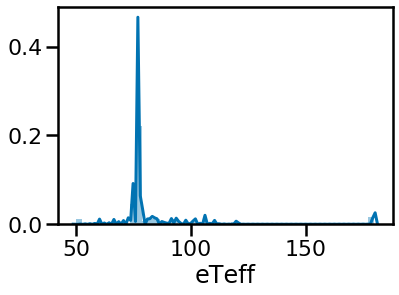

In [22]:
sns.distplot(ati.eTeff)

Check agreement between surface & seismic rotation period

The high period stars are not explained by any model we address here. However the uncertainties on period on these stars is very large. Further assessment is required.

- Plot seismic vs surface rotation periods

Comments from convo with Jen:
There probably is a smoking gun, but there are some issues.
- Why are there a bunch of non-subgiant stars in the subgiant spot?
- Where would my priors dump a rotation period that samples from the priors?
- Where are all the stars around 6000-5000 degrees at low (fast) periods. Shouldn't we be detecting those?
- What do I report if there isn't any splitting detectable?
- I need to properly vet which stars belong and which ones don't

## New plots

In [23]:
def mnras_size(fig_width_pt, square=False):
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0     # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    return [fig_width,fig_height]

In [24]:
ati.columns

Index(['KIC', 'Teff', 'age', 'dnu', 'eTeff', 'ednu', 'efeh', 'enumax', 'feh',
       'loage', 'lomodlogg', 'lomodmass', 'lomodrad', 'modlogg', 'modmass',
       'modrad', 'numax', 'source', 'upage', 'upmodlogg', 'upmodmass',
       'upmodrad', 'G', 'bprp', 'hrclass', 'nus*', 'l_nus*', 'u_nus*', 'cosi',
       'l_cosi', 'u_cosi', 'i', 'l_i', 'u_i', 'nus', 'l_nus', 'u_nus', 'P',
       'l_P', 'u_P', 'vsini', 'l_vsini', 'u_vsini', 'fit_numax', 'efit_numax',
       'fit_d01', 'efit_d01', 'fit_d02', 'efit_d02', 'fit_epsilon',
       'efit_epsilon', 'V1', 'eV1', 'V2', 'eV2', 'rhat_flag', 'eye_flag',
       'neff_xsplit', 'neff_cosi', 'neff_split', 'neff_i', 'ebprp', 'Flag',
       'McQP', 'e_McQP', 'SP', 'e_SP', 'NP', 'e_NP', 'jvsP', 'GP', 'e_GP'],
      dtype='object')

In [25]:
s = ati.u_P / ati.P < 1

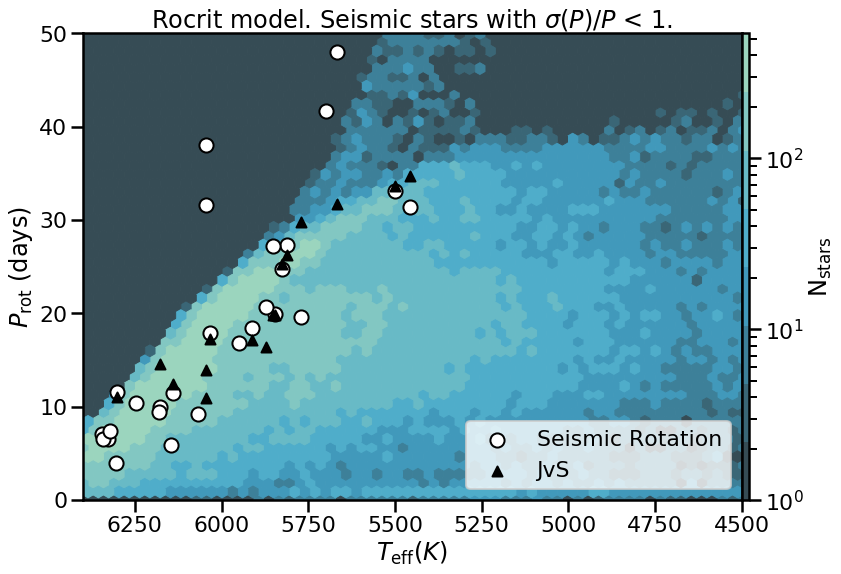

In [26]:
fig = plt.figure(figsize=mnras_size(1000))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
# ax.scatter(ati.Teff[s], ati.P[s], c='w', s=50,zorder=5, label='Seismic Rotation Only')
# ax.scatter(ati.Teff[s], ati.P[s], c='k', s=100,zorder=4)
# ax.errorbar(ati.Teff[s], ati.P[s], c='w', lw=2, 
#             xerr=ati.eTeff[s], yerr=[ati.l_P[s], ati.u_P[s]], fmt='|', zorder=3)

s2 = ati.Flag[s] == 1.0
ax.scatter(ati.Teff[s][s2], ati.P[s][s2], c='w', s=200, ec='k', zorder=5, label='Seismic Rotation')
# ax.scatter(ati.Teff[s][s2], ati.McQP[s][s2], c='k', marker='*', s=100,zorder=5, label='McQuillain')
# ax.scatter(ati.Teff[s][s2], ati.NP[s][s2], c='k', marker='v', s=100,zorder=5, label='Nielsen')
ax.scatter(ati.Teff[s][s2], ati.jvsP[s][s2], c='k', marker='^', s=100,zorder=5, label='JvS')



ax.set_ylim(0, 50)
ax.set_xlim(6400, 4500)
ax.set_title('Rocrit model. Seismic stars with $\sigma(P)/P$ < 1.')
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.legend(loc='lower right')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

In [27]:
ati.columns

Index(['KIC', 'Teff', 'age', 'dnu', 'eTeff', 'ednu', 'efeh', 'enumax', 'feh',
       'loage', 'lomodlogg', 'lomodmass', 'lomodrad', 'modlogg', 'modmass',
       'modrad', 'numax', 'source', 'upage', 'upmodlogg', 'upmodmass',
       'upmodrad', 'G', 'bprp', 'hrclass', 'nus*', 'l_nus*', 'u_nus*', 'cosi',
       'l_cosi', 'u_cosi', 'i', 'l_i', 'u_i', 'nus', 'l_nus', 'u_nus', 'P',
       'l_P', 'u_P', 'vsini', 'l_vsini', 'u_vsini', 'fit_numax', 'efit_numax',
       'fit_d01', 'efit_d01', 'fit_d02', 'efit_d02', 'fit_epsilon',
       'efit_epsilon', 'V1', 'eV1', 'V2', 'eV2', 'rhat_flag', 'eye_flag',
       'neff_xsplit', 'neff_cosi', 'neff_split', 'neff_i', 'ebprp', 'Flag',
       'McQP', 'e_McQP', 'SP', 'e_SP', 'NP', 'e_NP', 'jvsP', 'GP', 'e_GP'],
      dtype='object')

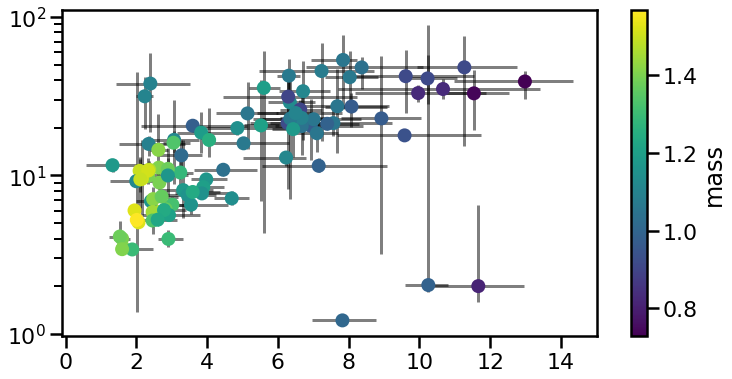

In [28]:
fig = plt.figure(figsize=(12,6))
c = plt.scatter(ati.age, ati.P, c=ati.modmass,zorder=2)
plt.errorbar(ati.age, ati.P, xerr=[ati.loage, ati.upage], yerr=[ati.l_P, ati.u_P], fmt='|', c='k', alpha=.5, zorder=1)
fig.colorbar(c, label='mass')
plt.yscale('log')

In [29]:
ati.columns

Index(['KIC', 'Teff', 'age', 'dnu', 'eTeff', 'ednu', 'efeh', 'enumax', 'feh',
       'loage', 'lomodlogg', 'lomodmass', 'lomodrad', 'modlogg', 'modmass',
       'modrad', 'numax', 'source', 'upage', 'upmodlogg', 'upmodmass',
       'upmodrad', 'G', 'bprp', 'hrclass', 'nus*', 'l_nus*', 'u_nus*', 'cosi',
       'l_cosi', 'u_cosi', 'i', 'l_i', 'u_i', 'nus', 'l_nus', 'u_nus', 'P',
       'l_P', 'u_P', 'vsini', 'l_vsini', 'u_vsini', 'fit_numax', 'efit_numax',
       'fit_d01', 'efit_d01', 'fit_d02', 'efit_d02', 'fit_epsilon',
       'efit_epsilon', 'V1', 'eV1', 'V2', 'eV2', 'rhat_flag', 'eye_flag',
       'neff_xsplit', 'neff_cosi', 'neff_split', 'neff_i', 'ebprp', 'Flag',
       'McQP', 'e_McQP', 'SP', 'e_SP', 'NP', 'e_NP', 'jvsP', 'GP', 'e_GP'],
      dtype='object')

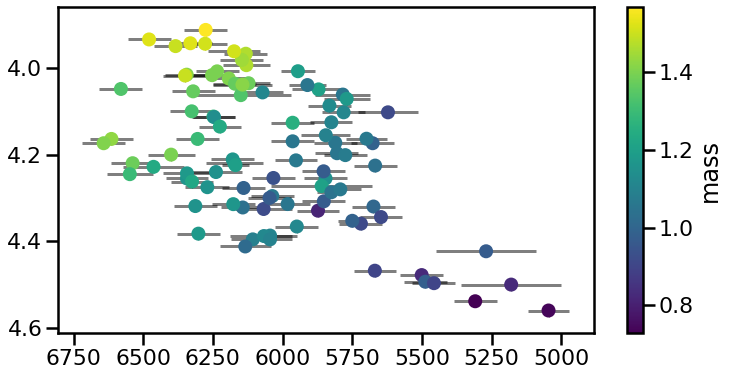

In [30]:
fig = plt.figure(figsize=(12,6))
c = plt.scatter(ati.Teff, ati.modlogg, c=ati.modmass,zorder=2)
plt.errorbar(ati.Teff, ati.modlogg, xerr=ati.eTeff, yerr=[ati.lomodlogg, ati.upmodlogg], fmt='|', c='k', alpha=.5, zorder=1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
fig.colorbar(c, label='mass')

Tayar & Pinsonneault 2018

In [31]:
z = ati.loc[(ati.Teff > 6200)]
a = ati.loc[(ati.Teff > 5900)&(ati.Teff < 6200)]
b = ati.loc[(ati.Teff > 5600)&(ati.Teff < 5900)]
c = ati.loc[(ati.Teff > 5100)&(ati.Teff < 5400)]

AttributeError: 'DataFrame' object has no attribute 'ratio'

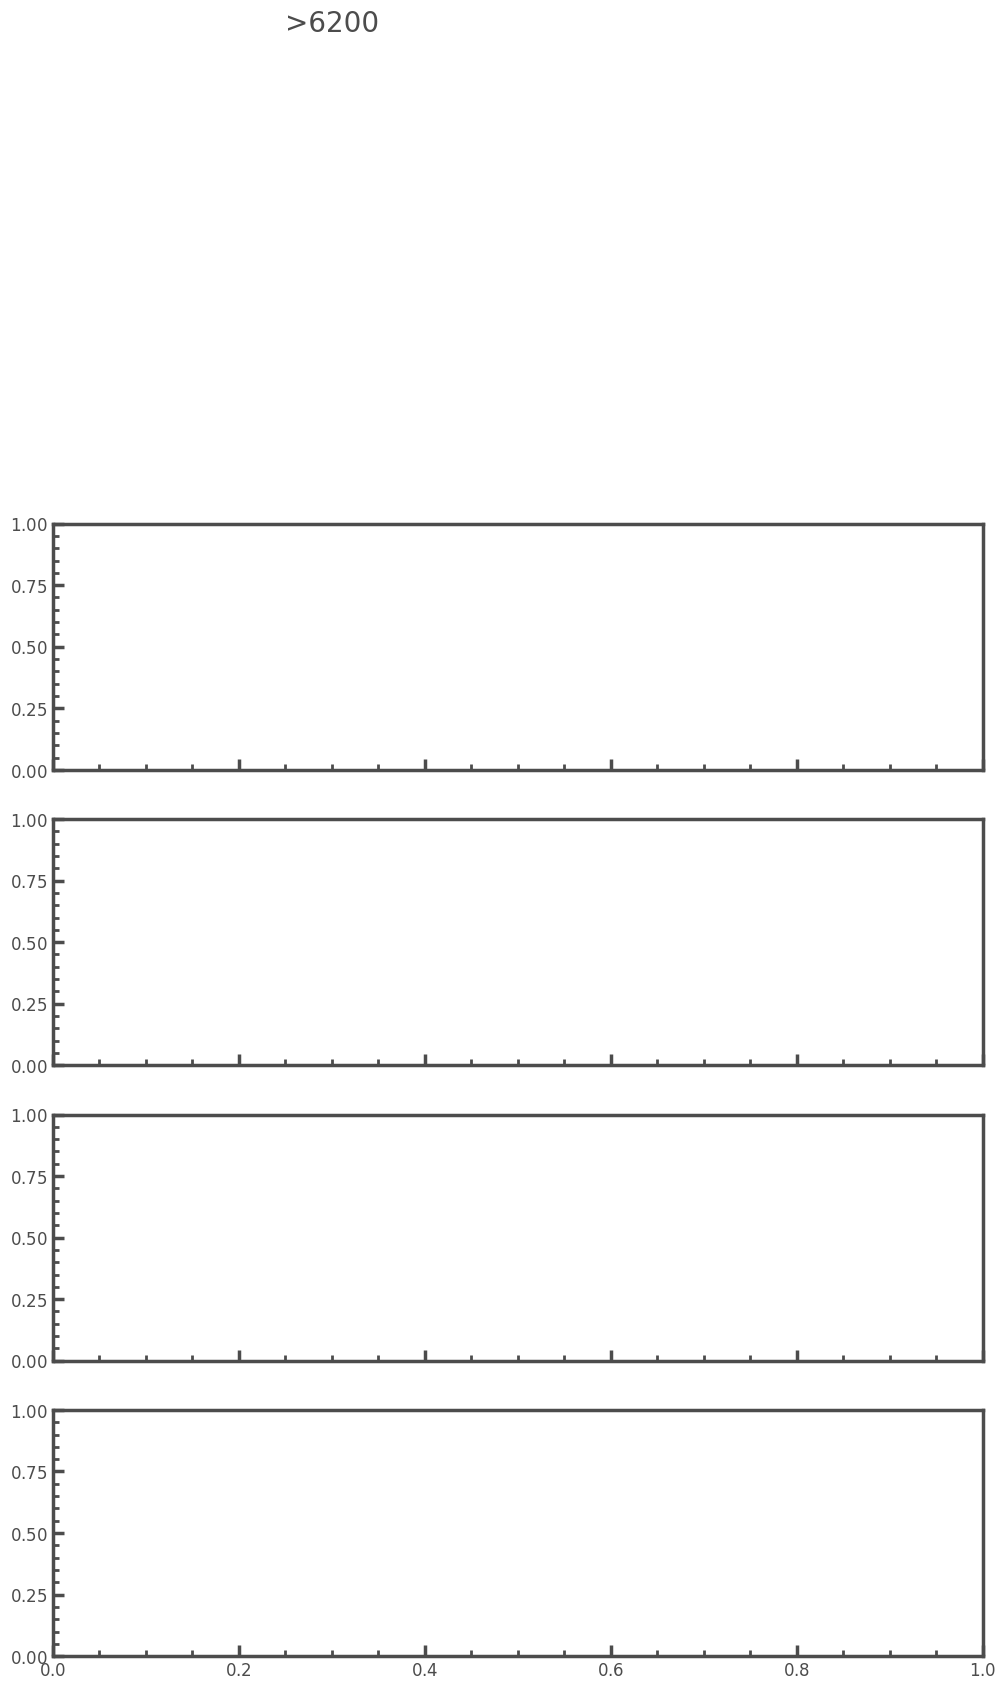

In [32]:
import lightkurve as lk
with plt.style.context(lk.MPLSTYLE):

    sns.set_palette('colorblind')
    fig, ax = plt.subplots(4, sharex=True, sharey=True, figsize=(12,15))
    ax[0].text(.25, 3., '>6200',fontsize=20)
    col = ax[0].scatter(z.age,  z.ratio, lw=1, ec='grey', c=z.Teff,s=120, zorder=2,
                     vmin = kal.Teff.min(), vmax=kal.Teff.max())
    ax[0].errorbar(z.age, z.ratio, yerr=[z.l_ratio, z.u_ratio], xerr=[z.loage, z.upage],
                fmt='|', zorder=1, color='grey')    
    
    ax[1].text(.25, 3., '5900-6200',fontsize=20)
    col = ax[1].scatter(a.age,  a.ratio, lw=1, ec='grey', c=a.Teff,s=120, zorder=2,
                     vmin = kal.Teff.min(), vmax=kal.Teff.max())
    ax[1].errorbar(a.age, a.ratio, yerr=[a.l_ratio, a.u_ratio], xerr=[a.loage, a.upage],
                fmt='|', zorder=1, color='grey')
    
    ax[2].text(.25, 3., '5600-5900',fontsize=20)    
    col = ax[2].scatter(b.age,  b.ratio, lw=1, ec='grey', c=b.Teff,s=120, zorder=2,
                     vmin = kal.Teff.min(), vmax=kal.Teff.max())
    ax[2].errorbar(b.age, b.ratio, yerr=[b.l_ratio, b.u_ratio], xerr=[b.loage, b.upage],
                fmt='|', zorder=1, color='grey')

    ax[3].text(.25, 3., '5100-5400',fontsize=20)
    col = ax[3].scatter(c.age,  c.ratio, lw=1, ec='grey', c=c.Teff,s=120, zorder=2,
                     vmin = kal.Teff.min(), vmax=kal.Teff.max())
    ax[3].errorbar(c.age, c.ratio, yerr=[c.l_ratio, c.u_ratio], xerr=[c.loage, c.upage],
                fmt='|', zorder=1, color='grey')    

    ax[2].scatter(sun['age'],sun['ratio'], s=200, c='white', ec='k',lw=2,zorder=3)
    ax[2].scatter(sun['age'],sun['ratio'], s=20, c='k',zorder=3)

    ax[0].axhline(1., ls=':', lw=4, zorder=1)
    ax[1].axhline(1., ls=':', lw=4, zorder=1)
    ax[2].axhline(1., ls=':', lw=4, zorder=1)   
    ax[3].axhline(1., ls=':', lw=4, zorder=1)

    ax[3].set_xlabel(r'Age (Gyr)')
    ax[0].set_ylabel(r'$P_{\rm predicted}$ / $P_{\rm obs}$')
    ax[1].set_ylabel(r'$P_{\rm predicted}$ / $P_{\rm obs}$')
    ax[2].set_ylabel(r'$P_{\rm predicted}$ / $P_{\rm obs}$')
    ax[3].set_ylabel(r'$P_{\rm predicted}$ / $P_{\rm obs}$')
    
    
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[3].spines['right'].set_visible(False)
    ax[3].spines['top'].set_visible(False)    
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['top'].set_visible(False)

#     ax[0].set_ylim(0., 2.)
#     ax[1].set_ylim(0., 2.)
#     ax[2].set_ylim(0., 2.)
#     ax[3].set_ylim(0., 2.)
    
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.13, 0.01, .75])
    fig.colorbar(col, cax=cbar_ax, label='Spectroscopic Teff (K)')

    
#     fig.tight_layout()
    plt.subplots_adjust(hspace=0.05)
#     plt.savefig('PvPred.pdf')
    plt.show()

In [ ]:
fig = plt.figure(figsize=(18,6))
ax = plt.gca()
c = ax.hexbin(standard.Teff, standard.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(ati.Teff[s], ati.P[s], c='w', s=50,zorder=5)
ax.scatter(ati.Teff[s], ati.P[s], c='k', s=100,zorder=4)
ax.errorbar(ati.Teff[s], ati.P[s], c='w', lw=2, 
            xerr=ati.eTeff[s], yerr=[ati.l_P[s], ati.u_P[s]], fmt='|', zorder=3)

ax.set_ylim(0, 50)
ax.set_xlim(6400, 4500)
ax.set_title('Standard Rotational Evolution')
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

In [ ]:
fig = plt.figure(figsize=(18,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(ati.Teff[s], ati.P[s], c='w', s=50,zorder=5)
ax.scatter(ati.Teff[s], ati.P[s], c='k', s=100,zorder=4)
ax.errorbar(ati.Teff[s], ati.P[s], c='w', lw=2, 
            xerr=ati.eTeff[s], yerr=[ati.l_P[s], ati.u_P[s]], fmt='|', zorder=3)

ax.set_ylim(0, 50)
ax.set_xlim(6400, 4500)
ax.set_title('Evolution with Magnetic Braking')
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

In [ ]:
standard.columns

In [ ]:
ati.columns

In [ ]:
fig = plt.figure(figsize=(18,6))
ax = plt.gca()
c = ax.hexbin(standard.Age, standard.P, cmap=cmap, bins='log')
ax.scatter(ati.age[s], ati.P[s], c='w', s=50,zorder=5)
ax.scatter(ati.age[s], ati.P[s], c='k', s=100,zorder=4)
ax.errorbar(ati.age[s], ati.P[s], c='w', lw=2, 
            xerr=[ati.loage[s], ati.upage[s]], yerr=[ati.l_P[s], ati.u_P[s]], fmt='|', zorder=3)
ax.set_xlim(0, standard.Age.max())
ax.set_ylim(0, 50)
# ax.set_xlim(6400, 4500)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$Age (Gyr)$')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

In [ ]:
fig = plt.figure(figsize=(18,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Age, rocrit.P, cmap=cmap, bins='log')
ax.scatter(ati.age[s], ati.P[s], c=ati.bprp[s], s=50,zorder=5)
ax.scatter(ati.age[s], ati.P[s], c='k', s=100,zorder=4)
ax.errorbar(ati.age[s], ati.P[s], c='w', lw=2, 
            xerr=[ati.loage[s], ati.upage[s]], yerr=[ati.l_P[s], ati.u_P[s]], fmt='|', zorder=3)
ax.set_xlim(0, standard.Age.max())
ax.set_ylim(0, 50)
# ax.set_xlim(6400, 4500)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$Age (Gyr)$')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

In [ ]:
t = standard.sample(10000)

In [ ]:
fig = plt.figure(figsize=(18,6))
ax = plt.gca()
c = ax.scatter(t.Age, t.P, c=t.Teff, alpha=.1)
ax.scatter(ati.age[s], ati.P[s], c=ati.Teff[s], s=50,zorder=5)
ax.scatter(ati.age[s], ati.P[s], c='k', s=100,zorder=4)
ax.errorbar(ati.age[s], ati.P[s], c='w', lw=2, 
            xerr=[ati.loage[s], ati.upage[s]], yerr=[ati.l_P[s], ati.u_P[s]], fmt='|', zorder=3)
ax.set_xlim(0, t.Age.max())
ax.set_ylim(0, 50)
# ax.set_xlim(6400, 4500)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$Age (Gyr)$')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)